# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [24]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [25]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [29]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [27]:
centroids = torch.rand(n_clusters, 2)*70-35
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [30]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [31]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [32]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [33]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

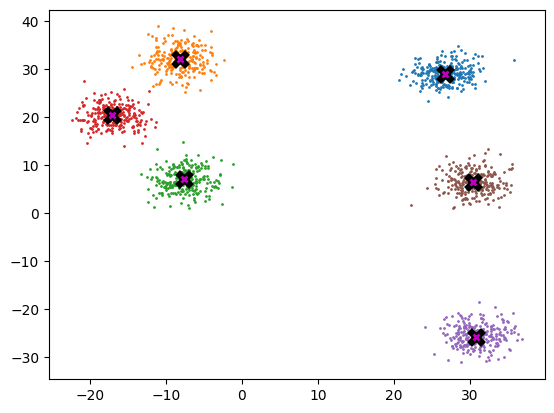

In [34]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [35]:
midp = data.mean(0)
data[:,0].mean(), data[:,1].mean(), midp

(tensor(9.222), tensor(11.604), tensor([ 9.222, 11.604]))

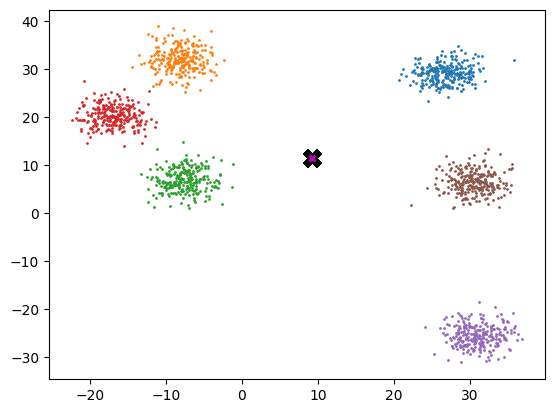

In [36]:
plot_data([midp]*6, data, n_samples)
# plot_data([midp], data, 1500)

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!
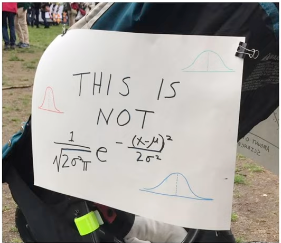

$$
G(d) = \frac{1}{bw \sqrt{2\pi}} 
\exp\left(-\frac{d^2}{2bw^2}\right)
$$


In [37]:
# 高斯核函数 (Gaussian Kernel)
# 公式: G(d) = exp(-0.5 * (d/bw)^2) / (bw * sqrt(2π))
#
# 想象你站在一个点上, 向四周看:
#   - d: 其他点到你的距离
#   - bw (bandwidth): 你的"视野范围", 即标准差
#
# 计算过程拆解:
#   d/bw          → 把距离按视野范围归一化, 近的点值大, 远的点值小
#   (d/bw)**2     → 平方, 让距离差异更明显
#   -0.5*(d/bw)^2 → 取负, 距离越大值越负
#   exp(...)      → e的指数, 把负值映射到 (0, 1) 区间:
#                      距离=0 → exp(0) = 1 (最近, 权重最大)
#                      距离=bw → exp(-0.5) ≈ 0.6
#                      距离=2bw → exp(-2) ≈ 0.14
#                      距离=3bw → exp(-4.5) ≈ 0.01 (几乎忽略)
#   / (bw*√2π)    → 归一化系数, 使曲线下面积=1 (概率密度)
#
# 效果: 近处的点获得大权重, 远处的点权重趋近于0, 形成一个"钟形曲线"
#        ___
#       /   \
#      /     \
#   __/       \__
#   ←── bw ──→
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [38]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

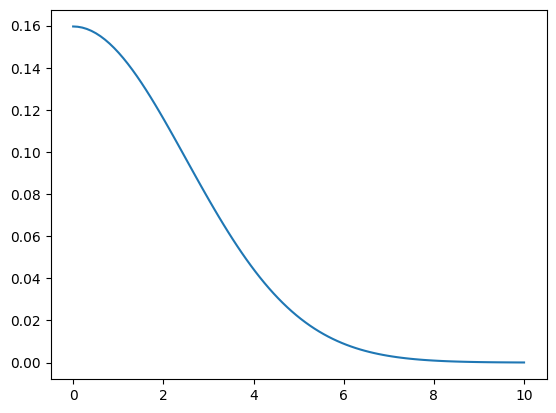

In [39]:
plot_func(partial(gaussian, bw=2.5))

In [42]:
partial

functools.partial

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [43]:
def tri(d, i): return (-d+i).clamp_min(0)/i

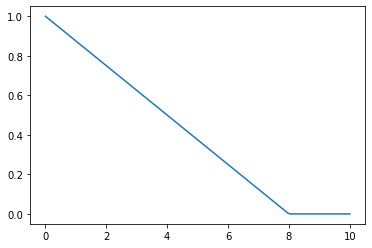

In [ ]:
plot_func(partial(tri, i=8))

In [44]:
X = data.clone()
x = data[0]

In [45]:
x

tensor([26.204, 26.349])

In [46]:
x.shape,X.shape,x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [47]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [59]:
(x-X)[:8], ((x-X)**2)[:8], ((x-X)**2)[:8].sum(1),((x-X)**2)[:8].sum(1).sqrt()

(tensor([[ 0.000,  0.000],
         [ 0.513, -3.865],
         [-4.227, -2.345],
         [ 0.557, -3.685],
         [-5.033, -3.745],
         [-4.073, -0.638],
         [-3.415, -5.601],
         [-1.920, -5.686]]),
 tensor([[ 0.000,  0.000],
         [ 0.263, 14.936],
         [17.871,  5.498],
         [ 0.310, 13.576],
         [25.328, 14.022],
         [16.585,  0.407],
         [11.664, 31.366],
         [ 3.687, 32.333]]),
 tensor([ 0.000, 15.199, 23.369, 13.887, 39.350, 16.993, 43.031, 36.020]),
 tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002]))

In [60]:
# rewrite using torch.einsum
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [75]:
# rewrite using torch.einsum
x, X, torch.einsum('ij,ij->i', x-X, x-X).sqrt()

(tensor([26.204, 26.349]),
 tensor([[26.204, 26.349],
         [25.691, 30.213],
         [30.431, 28.693],
         ...,
         [30.772,  9.323],
         [29.354,  3.960],
         [31.168,  5.309]]),
 tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617]))

In [61]:
weight = gaussian(dist, 2.5)
weight

tensor([0.160, 0.047, 0.025,  ..., 0.000, 0.000, 0.000])

In [62]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [66]:
weight[:,None].shape, weight[:,None], X

(torch.Size([1500, 1]),
 tensor([[0.160],
         [0.047],
         [0.025],
         ...,
         [0.000],
         [0.000],
         [0.000]]),
 tensor([[26.204, 26.349],
         [25.691, 30.213],
         [30.431, 28.693],
         ...,
         [30.772,  9.323],
         [29.354,  3.960],
         [31.168,  5.309]]))

In [67]:
weight[:,None]*X

tensor([[4.182, 4.205],
        [1.215, 1.429],
        [0.749, 0.706],
        ...,
        [0.000, 0.000],
        [0.000, 0.000],
        [0.000, 0.000]])

# Lp范数
L1 范数是指沿各个坐标轴方向的长度之和，例如：

$$
\|(3,4,5)\|_1 = |3| + |4| + |5| = 12
$$

L2 范数是指在坐标空间中的几何长度（欧几里得长度），例如：

$$
\|(3,4,5)\|_2 = \sqrt{|3|^2 + |4|^2 + |5|^2}
$$

一般地，对于向量 $(a,b,c)$，其 $L^p$ 范数定义为：

$$
\|(a,b,c)\|_p = \left( |a|^p + |b|^p + |c|^p \right)^{\frac{1}{p}}
$$

对于向量 $\mathbf{x} = (a,b,c)$，其 $p$ 范数定义为：

$$
\|\mathbf{x}\|_p = \left( \sum_{i=1}^{n} |x_i|^p \right)^{\frac{1}{p}}
$$


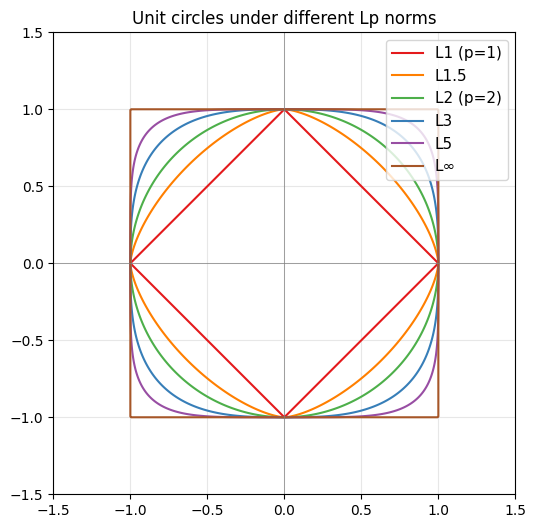

In [68]:
# 绘制不同Lp范数的单位"圆" (||x||_p = 1 的等高线)
# L1: 菱形, L2: 圆形, L∞: 正方形, 其他p值介于之间

t = torch.linspace(-1.5, 1.5, 500)
xx, yy = torch.meshgrid(t, t, indexing='xy')

fig, ax = plt.subplots(figsize=(6, 6))
norms = {'L1 (p=1)': 1, 'L1.5': 1.5, 'L2 (p=2)': 2, 'L3': 3, 'L5': 5}
colors = ['#e41a1c', '#ff7f00', '#4daf4a', '#377eb8', '#984ea3']

for (label, p), color in zip(norms.items(), colors):
    zz = (xx.abs()**p + yy.abs()**p)**(1/p)
    ax.contour(xx, yy, zz, levels=[1], colors=[color])
    ax.plot([], [], color=color, label=label)  # for legend

# L∞: max(|x|, |y|) = 1
zz_inf = torch.max(xx.abs(), yy.abs())
ax.contour(xx, yy, zz_inf, levels=[1], colors=['#a65628'])
ax.plot([], [], color='#a65628', label='L∞')

ax.set_aspect('equal')
ax.legend(fontsize=11)
ax.set_title('Unit circles under different Lp norms')
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)
ax.grid(True, alpha=0.3)
plt.show()

In [81]:
# Mean Shift 算法的单次迭代更新
# 核心思想: 把每个数据点移向其邻域的加权平均位置（"质心"），
#           权重由核函数决定——越近的点影响越大，远处的点几乎无影响。
#           反复迭代后，同一簇的点会汇聚到同一位置。
#
# 参数:
#   X: shape (n, 2) 的张量，所有数据点的坐标（会被原地修改）
def one_update(X):
    for i, x in enumerate(X):
        # 1. 计算当前点 x 到所有点的欧氏距离
        #    x - X: 广播 (2,) - (n,2) → (n,2)，每行是 x 与第 j 个点的坐标差
        #    (**2).sum(1): 对每行求平方和 → (n,)，即各点到 x 的距离平方
        #    sqrt: 开方得到欧氏距离 → (n,)
        dist = torch.sqrt(((x-X)**2).sum(1))

        # 2. 用核函数把距离转换为权重
        #    gaussian(dist, bw): 高斯核，bw 是带宽，衰减平滑
        #    tri(dist, r):       三角核，半径 r 内线性衰减，r 外权重为 0
        #    两者效果类似，三角核计算更快，高斯核更平滑
        weight = gaussian(dist, 2.5)
        # weight = tri(dist, 8)       # → (n,)，每个点对当前点 x 的影响权重

        # 3. 计算加权平均，将 x 移向邻域"质心"
        #    weight[:,None]*X: (n,1)*(n,2) → (n,2)，每个点坐标乘以其权重
        #    .sum(0):          沿点维度求和 → (2,)，加权坐标总和
        #    / weight.sum():   除以权重总和，得到加权平均位置
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [82]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [ ]:
%time X=meanshift(data)
centroids, centroids+2, X

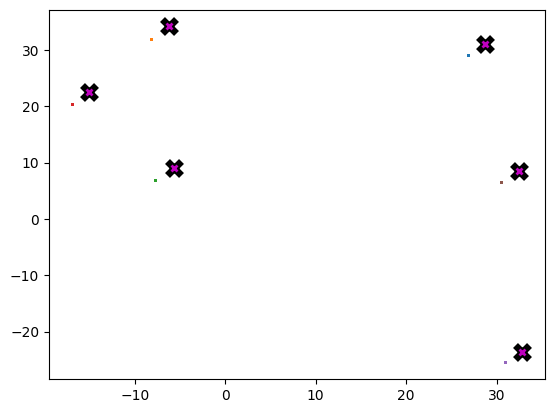

In [85]:
plot_data(centroids+2, X, n_samples)

## Animation

In [86]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [87]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [88]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [91]:
a = torch.randn(3, 2, 4)
a.shape, a[None,None,:,None,:,None].shape

(torch.Size([3, 2, 4]), torch.Size([1, 1, 3, 1, 2, 1, 4]))

In [92]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [93]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [94]:
dist_b(X, x)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [95]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [96]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [97]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[0.199, 0.030, 0.011,  ..., 0.000, 0.000, 0.000],
        [0.030, 0.199, 0.009,  ..., 0.000, 0.000, 0.000],
        [0.011, 0.009, 0.199,  ..., 0.000, 0.000, 0.000],
        [0.035, 0.199, 0.009,  ..., 0.000, 0.000, 0.000],
        [0.001, 0.004, 0.144,  ..., 0.000, 0.000, 0.000]])

In [98]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [99]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [100]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [101]:
num

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [102]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])

In [103]:
weight@X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])

In [104]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [105]:
num/div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [106]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [107]:
data = data.cuda()

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
X = meanshift(data).cpu()

In [ ]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

2 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


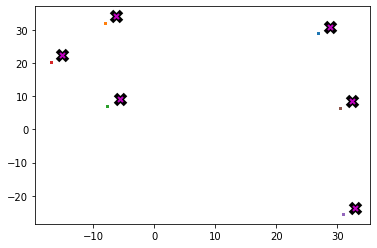

In [ ]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D